# Logistic Regression using Scikit-learn
Building a Greyhound Racing model with Scikit-learn Logistic Regression

## Overview

This tutorial will walk you through the different steps required to generate Greyhound racing winning probabilities
1. Download historic greyhound data from FastTrack API
2. Cleanse and normalise the data
3. Generate features using raw data
4. Build and train Classification models
5. Evaluate models performances

## Requirements

- You will need a Betfair API app key. If you don't have one please follow the steps outlined on the [The Automation Hub](https://betfair-datascientists.github.io/api/apiappkey/)
- You will need your own FastTrack security key. To apply for one, [contact the Betfair automation team](mailto:automation@betfair.com.au).
- This notebook and accompanying files is [shared on `betfair-downunder`'s Github](https://github.com/betfair-down-under/greyhound-modelling/tree/master). **TBC**

In [1]:
# Import libraries
import os
import sys

# Allow imports from src folder
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from dateutil import tz
from pandas.tseries.offsets import MonthEnd
from sklearn.preprocessing import MinMaxScaler
import itertools

import math
import numpy as np
import pandas as pd
import fasttrack as ft

from dotenv import load_dotenv
load_dotenv()

True

### Note - FastTrack API key
If you follow [README instructions](../README.md) to run this notebook locally, you should have configured a `.env` file with your FastTrack API key.
Otherwise you can set your API key below.

In [2]:
# Validate FastTrack API connection
api_key = os.getenv('FAST_TRACK_API_KEY', '<REPLACE WITH YOUR KEY>')
client = ft.Fasttrack(api_key)
track_codes = client.listTracks()

Valid Security Key


## 1. Download historic greyhound data from FastTrack API

The cell below downloads FastTrack AU race data for the past few months. Data is cached locally in the `data` folder so it can easily be reused for further processing.
Depending on the amount of data to retrieve, this can take a few hours.

In [3]:
# Import race data excluding NZ races
au_tracks_filter = list(track_codes[track_codes['state'] != 'NZ']['track_code'])

# Time window to import data
# First day of the month 46 months back from now
date_from = (datetime.today() - relativedelta(months=46)).replace(day=1).strftime('%Y-%m-%d')
# First day of previous month
date_to = (datetime.today() - relativedelta(months=1)).replace(day=1).strftime('%Y-%m-%d')

# Dataframes to populate data with
race_details = pd.DataFrame()
dog_results = pd.DataFrame()

# For each month, either fetch data from API or use local CSV file if we already have downloaded it
for start in pd.date_range(date_from, date_to, freq='MS'):
    start_date = start.strftime("%Y-%m-%d")
    end_date = (start + MonthEnd(1)).strftime("%Y-%m-%d")
    try:
        filename_races = f'FT_AU_RACES_{start_date}.csv'
        filename_dogs = f'FT_AU_DOGS_{start_date}.csv'

        filepath_races = f'../data/{filename_races}'
        filepath_dogs = f'../data/{filename_dogs}'

        print(f'Loading data from {start_date} to {end_date}')
        if os.path.isfile(filepath_races):
            # Load local CSV file
            month_race_details = pd.read_csv(filepath_races) 
            month_dog_results = pd.read_csv(filepath_dogs) 
        else:
            # Fetch data from API
            month_race_details, month_dog_results = client.getRaceResults(start_date, end_date, au_tracks_filter)
            month_race_details.to_csv(filepath_races, index=False)
            month_dog_results.to_csv(filepath_dogs, index=False)

        # Combine monthly data
        race_details = race_details.append(month_race_details, ignore_index=True)
        dog_results = dog_results.append(month_dog_results, ignore_index=True)
    except:
        print(f'Could not load data from {start_date} to {end_date}')

Loading data from 2017-12-01 to 2017-12-31
Loading data from 2018-01-01 to 2018-01-31
Loading data from 2018-02-01 to 2018-02-28
Loading data from 2018-03-01 to 2018-03-31
Loading data from 2018-04-01 to 2018-04-30
Loading data from 2018-05-01 to 2018-05-31
Loading data from 2018-06-01 to 2018-06-30
Loading data from 2018-07-01 to 2018-07-31
Loading data from 2018-08-01 to 2018-08-31


/home/bruno/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Loading data from 2018-09-01 to 2018-09-30
Loading data from 2018-10-01 to 2018-10-31
Loading data from 2018-11-01 to 2018-11-30
Loading data from 2018-12-01 to 2018-12-31
Loading data from 2019-01-01 to 2019-01-31
Loading data from 2019-02-01 to 2019-02-28
Loading data from 2019-03-01 to 2019-03-31
Loading data from 2019-04-01 to 2019-04-30
Loading data from 2019-05-01 to 2019-05-31
Loading data from 2019-06-01 to 2019-06-30
Loading data from 2019-07-01 to 2019-07-31
Loading data from 2019-08-01 to 2019-08-31
Loading data from 2019-09-01 to 2019-09-30
Loading data from 2019-10-01 to 2019-10-31
Loading data from 2019-11-01 to 2019-11-30
Loading data from 2019-12-01 to 2019-12-31
Loading data from 2020-01-01 to 2020-01-31
Loading data from 2020-02-01 to 2020-02-29
Loading data from 2020-03-01 to 2020-03-31
Loading data from 2020-04-01 to 2020-04-30
Loading data from 2020-05-01 to 2020-05-31
Loading data from 2020-06-01 to 2020-06-30
Loading data from 2020-07-01 to 2020-07-31
Loading dat

/home/bruno/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (10,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Loading data from 2021-06-01 to 2021-06-30
Loading data from 2021-07-01 to 2021-07-31
Loading data from 2021-08-01 to 2021-08-31
Loading data from 2021-09-01 to 2021-09-30


To better understand the data we retrieved, let's print the first few rows

In [4]:
# Race data
race_details.head()

,@id,RaceNum,RaceName,RaceTime,Distance,RaceGrade,Track,date
0,278896185,1,TRIPLE M BENDIGO 93.5,02:54PM,425m,Grade 6,Bendigo,01 Dec 17
1,278896189,2,GOLDEN CITY CONCRETE PUMPING,03:17PM,500m,Mixed 6/7,Bendigo,01 Dec 17
2,275589809,3,RAILWAY STATION HOTEL FINAL,03:38PM,500m,Mixed 6/7 Final,Bendigo,01 Dec 17
3,278896183,4,MCIVOR RD VETERINARY CLINIC,03:58PM,425m,Grade 5,Bendigo,01 Dec 17
4,278896179,5,GRV VIC BRED SERIES HT1,04:24PM,425m,Grade 5 Heat,Bendigo,01 Dec 17


In [5]:
# Individual dogs results
dog_results.head()

,@id,Place,DogName,Box,Rug,Weight,StartPrice,Handicap,Margin1,Margin2,PIR,Checks,Comments,SplitMargin,RunTime,Prizemoney,RaceId,TrainerId,TrainerName
0,124886334,1,VANDA MICK,2.0,2,32.0,$2.80F,NaN,0.49,NaN,S/231,0,NaN,6.79,24.66,NaN,278896185,66993,M Ellis
1,2027130024,2,DYNA ZAD,7.0,7,24.2,$6.60,NaN,0.49,0.49,M/843,4,NaN,6.95,24.69,NaN,278896185,115912,M Delbridge
2,1448760015,3,KLONDIKE GOLD,4.0,4,33.3,$16.60,NaN,1.83,1.34,M/422,0,NaN,6.81,24.79,NaN,278896185,94459,R Hayes
3,1449650024,4,FROSTY TIARA,3.0,3,26.8,$22.00,NaN,2.94,1.11,S/114,0,NaN,6.75,24.86,NaN,278896185,87428,R Morgan
4,118782592,5,GNOCCHI,1.0,1,29.6,$8.60,NaN,6.50,3.56,S/355,0,NaN,6.80,25.11,NaN,278896185,138164,J La Rosa


## 2. Cleanse and normalise the data

Here we do some basic data manipulation and cleansing to get variables into format that we can work with

In [6]:
# Clean up the race dataset
race_details = race_details.rename(columns = {'@id': 'FastTrack_RaceId'})
race_details['Distance'] = race_details['Distance'].apply(lambda x: int(x.replace("m", "")))
race_details['date_dt'] = pd.to_datetime(race_details['date'], format = '%d %b %y')

In [7]:
# Clean up the dogs results dataset
dog_results = dog_results.rename(columns = {'@id': 'FastTrack_DogId', 'RaceId': 'FastTrack_RaceId'})

# Combine dogs results with race attributes
dog_results = dog_results.merge(
    race_details[['FastTrack_RaceId', 'Distance', 'RaceGrade', 'Track', 'date_dt']], 
    how = 'left',
    on = 'FastTrack_RaceId'
)

# Convert StartPrice to probability
dog_results['StartPrice'] = dog_results['StartPrice'].apply(lambda x: None if x is None else float(x.replace('$', '').replace('F', '')) if isinstance(x, str) else x)
dog_results['StartPrice_probability'] = (1 / dog_results['StartPrice']).fillna(0)
dog_results['StartPrice_probability'] = dog_results.groupby('FastTrack_RaceId')['StartPrice_probability'].apply(lambda x: x / x.sum())

# Discard entries without results (scratched or did not finish)
dog_results = dog_results[~dog_results['Box'].isnull()]
dog_results['Box'] = dog_results['Box'].astype(int)

# Clean up other attributes
dog_results['RunTime'] = dog_results['RunTime'].astype(float)
dog_results['SplitMargin'] = dog_results['SplitMargin'].astype(float)
dog_results['Prizemoney'] = dog_results['Prizemoney'].astype(float).fillna(0)
dog_results['Place'] = pd.to_numeric(dog_results['Place'].apply(lambda x: x.replace("=", "") if isinstance(x, str) else 0), errors='coerce').fillna(0)
dog_results['win'] = dog_results['Place'].apply(lambda x: 1 if x == 1 else 0)

The cell below shows some normalisation techniques
- Apply `Log base 10` transformation to `Prizemoney` and `Place`
- Apply `inverse` transformation to `Place`
- Combine `RunTime` and `Distance` to generate `Speed` value

In [8]:
# Normalise some of the raw values
dog_results['Prizemoney_norm'] = np.log10(dog_results['Prizemoney'] + 1) / 12
dog_results['Place_inv'] = (1 / dog_results['Place']).fillna(0)
dog_results['Place_log'] = np.log10(dog_results['Place'] + 1).fillna(0)
dog_results['RunSpeed'] = (dog_results['RunTime'] / dog_results['Distance']).fillna(0)

## 3. Generate features using raw data

### Calculate median winner time by Track/Distance

To compare individual runner times, we extract the median winner time for each Track/Distance and use it as a reference time.

In [9]:
# Calculate median winner time per track/distance
win_results = dog_results[dog_results['win'] == 1]
median_win_time = pd.DataFrame(data=win_results[win_results['RunTime'] > 0].groupby(['Track', 'Distance'])['RunTime'].median()).rename(columns={"RunTime": "RunTime_median"}).reset_index()
median_win_split_time = pd.DataFrame(data=win_results[win_results['SplitMargin'] > 0].groupby(['Track', 'Distance'])['SplitMargin'].median()).rename(columns={"SplitMargin": "SplitMargin_median"}).reset_index()
median_win_time.head()

,Track,Distance,RunTime_median
0,Albion Park,331,19.180
1,Albion Park,395,22.860
2,Albion Park,520,30.220
3,Albion Park,600,35.100
4,Albion Park,710,42.005


### Calculate Track speed index

Some tracks are run faster than other, we calculate here a `speed_index` using the track reference time over the travelled distance. The lower the `speed_index`, the faster the track is. We use `MinMaxScaler` to scale `speed_index` values between zero and one.

In [10]:
# Calculate track speed index
median_win_time['speed_index'] = (median_win_time['RunTime_median'] / median_win_time['Distance'])
median_win_time['speed_index'] = MinMaxScaler().fit_transform(median_win_time[['speed_index']])
median_win_time.head()

,Track,Distance,RunTime_median,speed_index
0,Albion Park,331,19.180,0.471787
1,Albion Park,395,22.860,0.460736
2,Albion Park,520,30.220,0.497773
3,Albion Park,600,35.100,0.556644
4,Albion Park,710,42.005,0.657970


### Compare individual times with track reference time

For each dog result, we compare the runner time with the reference time using the forumla `(track reference time) / (runner time)` and normalise the result. The higher the value, the quicker the dog was.

In [11]:
# Compare dogs finish time with median winner time
dog_results = dog_results.merge(median_win_time, on=['Track', 'Distance'], how='left')
dog_results = dog_results.merge(median_win_split_time, on=['Track', 'Distance'], how='left')

# Normalise time comparison
dog_results['RunTime_norm'] = (dog_results['RunTime_median'] / dog_results['RunTime']).clip(0.9, 1.1)
dog_results['RunTime_norm'] = MinMaxScaler().fit_transform(dog_results[['RunTime_norm']])
dog_results['SplitMargin_norm'] = (dog_results['SplitMargin_median'] / dog_results['SplitMargin']).clip(0.9, 1.1)
dog_results['SplitMargin_norm'] = MinMaxScaler().fit_transform(dog_results[['SplitMargin_norm']])
dog_results.head()

,FastTrack_DogId,Place,DogName,Box,Rug,Weight,StartPrice,Handicap,Margin1,Margin2,...,win,Prizemoney_norm,Place_inv,Place_log,RunSpeed,RunTime_median,speed_index,SplitMargin_median,RunTime_norm,SplitMargin_norm
0,124886334,1.0,VANDA MICK,2,2,32.0,2.8,NaN,0.49,NaN,...,1,0.0,1.000000,0.301030,0.058024,24.21,0.321642,6.63,0.408759,0.382180
1,2027130024,2.0,DYNA ZAD,7,7,24.2,6.6,NaN,0.49,0.49,...,0,0.0,0.500000,0.477121,0.058094,24.21,0.321642,6.63,0.402795,0.269784
2,1448760015,3.0,KLONDIKE GOLD,4,4,33.3,16.6,NaN,1.83,1.34,...,0,0.0,0.333333,0.602060,0.058329,24.21,0.321642,6.63,0.383017,0.367841
3,1449650024,4.0,FROSTY TIARA,3,3,26.8,22.0,NaN,2.94,1.11,...,0,0.0,0.250000,0.698970,0.058494,24.21,0.321642,6.63,0.369268,0.411111
4,118782592,5.0,GNOCCHI,1,1,29.6,8.6,NaN,6.50,3.56,...,0,0.0,0.200000,0.778151,0.059082,24.21,0.321642,6.63,0.320789,0.375000


### Barrier winning probabilities

The barrier dogs start from play a big part in the race so we calculate the winning percentage for each `Barrier/Track/Distance`

In [12]:
# Calculate box winning percentage for each track/distance
box_win_percent = pd.DataFrame(data=dog_results.groupby(['Track', 'Distance', 'Box'])['win'].mean()).rename(columns={"win": "box_win_percent"}).reset_index()
# Add to dog results dataframe
dog_results = dog_results.merge(box_win_percent, on=['Track', 'Distance', 'Box'], how='left')
# Display example of barrier winning probabilities
display(box_win_percent.head(8))

,Track,Distance,Box,box_win_percent
0,Albion Park,331,1,0.195652
1,Albion Park,331,2,0.153472
2,Albion Park,331,3,0.125446
3,Albion Park,331,4,0.124615
4,Albion Park,331,5,0.116135
5,Albion Park,331,6,0.105144
6,Albion Park,331,7,0.104770
7,Albion Park,331,8,0.115095


### Generate time based features

Now that we have a set of basic features for individual dog results, we need to aggregate them into a single feature vector.

To do so, we calculate the `min`, `max`, `mean`, `median`, `std` of features previously caculated over different time windows `28`, `91` and `365` days:
- RunTime_norm
- SplitMargin_norm
- Place_inv
- Place_log
- Prizemoney_norm

Depending on the dataset size, this can take several minutes

In [13]:
# Generate rolling window features
dataset = dog_results.copy()
dataset = dataset.set_index(['FastTrack_DogId', 'date_dt']).sort_index()

# Use rolling window of 28, 91 and 365 days
rolling_windows = ['28D', '91D', '365D']
# Features to use for rolling windows calculation
features = ['RunTime_norm', 'SplitMargin_norm', 'Place_inv', 'Place_log', 'Prizemoney_norm']
# Aggregation functions to apply
aggregates = ['min', 'max', 'mean', 'median', 'std']
# Keep track of generated feature names
feature_cols = ['speed_index', 'box_win_percent']

for rolling_window in rolling_windows:
        print(f'Processing rolling window {rolling_window}')

        rolling_result = (
            dataset
            .reset_index(level=0)
            .groupby('FastTrack_DogId')[features]
            .rolling(rolling_window)
            .agg(aggregates)
            .shift(1)
        )

        # Generate list of rolling window feature names (eg: RunTime_norm_min_365D)
        agg_features_cols = [f'{f}_{a}_{rolling_window}' for f, a in itertools.product(features, aggregates)]
        # Add features to dataset
        dataset[agg_features_cols] = rolling_result
        # Keep track of generated feature names
        feature_cols.extend(agg_features_cols)

Processing rolling window 28D
Processing rolling window 91D
Processing rolling window 365D


In [14]:
# Replace missing values with 0
dataset.fillna(0, inplace=True)
display(dataset.head(8))

Place        DogName  Box  Rug  Weight  \
FastTrack_DogId date_dt                                              
-2143487296     2017-12-14    6.0  JEWELLED COIN    7    7    26.6   
                2017-12-21    4.0  JEWELLED COIN    5    5    26.8   
                2017-12-26    3.0  JEWELLED COIN    3    3    27.1   
                2017-12-30    7.0  JEWELLED COIN    7    9    26.4   
                2018-01-02    8.0  JEWELLED COIN    5    5    26.8   
                2018-01-08    4.0  JEWELLED COIN    1    1    27.2   
                2018-01-10    2.0  JEWELLED COIN    5    5    27.3   
                2018-01-17    2.0  JEWELLED COIN    3    3    27.4   

                            StartPrice  Handicap  Margin1  Margin2   PIR  ...  \
FastTrack_DogId date_dt                                                   ...   
-2143487296     2017-12-14        13.1       0.0     8.25     0.14    55  ...   
                2017-12-21         9.7       0.0    13.50     3.00   555  ...   
                2017-12-26        21.5       0.0     6.75     2.29   642  ...   
                2017-12-30        48.1       0.0    21.75     2.29  7777  ...   
                2018-01-02        32.7       0.0    15.75     0.00   888  ...   
                2018-01-08         2.5       0.0     6.50     1.29  5443  ...   
                2018-01-10         8.5       0.0     2.00     2.14   442  ...   
                2018-01-17         7.3       0.0     5.25     5.14   433  ...   

                            Place_log_min_365D Place_log_max_365D  \
FastTrack_DogId date_dt                                             
-2143487296     2017-12-14            0.000000           0.000000   
                2017-12-21            0.845098           0.845098   
                2017-12-26            0.698970           0.845098   
                2017-12-30            0.602060           0.845098   
                2018-01-02            0.602060           0.903090   
                2018-01-08            0.602060           0.954243   
                2018-01-10            0.602060           0.954243   
                2018-01-17            0.477121           0.954243   

                            Place_log_mean_365D  Place_log_median_365D  \
FastTrack_DogId date_dt                                                  
-2143487296     2017-12-14             0.000000               0.000000   
                2017-12-21             0.845098               0.845098   
                2017-12-26             0.772034               0.772034   
                2017-12-30             0.715376               0.698970   
                2018-01-02             0.762305               0.772034   
                2018-01-08             0.800692               0.845098   
                2018-01-10             0.783738               0.772034   
                2018-01-17             0.739936               0.698970   

                            Place_log_std_365D  Prizemoney_norm_min_365D  \
FastTrack_DogId date_dt                                                    
-2143487296     2017-12-14            0.000000                       0.0   
                2017-12-21            0.000000                       0.0   
                2017-12-26            0.103328                       0.0   
                2017-12-30            0.122347                       0.0   
                2018-01-02            0.137070                       0.0   
                2018-01-08            0.146490                       0.0   
                2018-01-10            0.137448                       0.0   
                2018-01-17            0.170804                       0.0   

                            Prizemoney_norm_max_365D  \
FastTrack_DogId date_dt                                
-2143487296     2017-12-14                  0.000000   
                2017-12-21                  0.000000   
                2017-12-26                  0.142298   
                2017-12-30                 

As we use up to a year of data to generate our feature set, we exclude the first year of the dataset from our training dataset

In [15]:
# Only keep data after 2018-12-01
model_df = dataset.reset_index()
feature_cols = np.unique(feature_cols).tolist()
model_df = model_df[model_df['date_dt'] >= '2018-12-01']
model_df = model_df[['date_dt', 'FastTrack_RaceId', 'DogName', 'win', 'StartPrice_probability'] + feature_cols]

# Only train model off of races where each dog has a value for each feature
races_exclude = model_df[model_df.isnull().any(axis = 1)]['FastTrack_RaceId'].drop_duplicates()
model_df = model_df[~model_df['FastTrack_RaceId'].isin(races_exclude)]

## 4. Build and train Regression models

### Logistic Regression

The dataset is split between training and validation:
- train dataset: from 2018-12-01 to 2020-12-31
- validation dataset: from 2021-01-01

The next cell trains a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model and uses the `win` flag (0=lose, 1=win) as a target.

In [16]:
from matplotlib import pyplot
from matplotlib.pyplot import figure

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize

# Split the data into train and test data
train_data = model_df[model_df['date_dt'] < '2021-01-01'].reset_index(drop = True).sample(frac=1)
test_data = model_df[model_df['date_dt'] >= '2021-01-01'].reset_index(drop = True)

# Use our previously built features set columns as Training vector
# Use win flas as Targer vector
train_x, train_y = train_data[feature_cols], train_data['win']
test_x, test_y = test_data[feature_cols], test_data['win']

# Build a LogisticRegression model
model = LogisticRegression(verbose=0, n_jobs=-1)

# Train the model
print(f'Training on {len(train_x):,} samples with {len(feature_cols)} features')
model.fit(train_x, train_y)

Training on 630,306 samples with 77 features


LogisticRegression(n_jobs=-1)

## 5. Evaluate models performances

### Predictions distribution

To get a better feel of what our models are predicting, we can plot the generated probabilities distribution and compare them with Start Prices probabilities distribution.

In [17]:
# Generate runner win predictions
dog_win_probabilities = model.predict_proba(test_x)[:,1]
test_data['prob_LogisticRegression'] = dog_win_probabilities
# Normalise probabilities
test_data['prob_LogisticRegression'] = test_data.groupby('FastTrack_RaceId')['prob_LogisticRegression'].apply(lambda x: x / sum(x))

/home/bruno/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


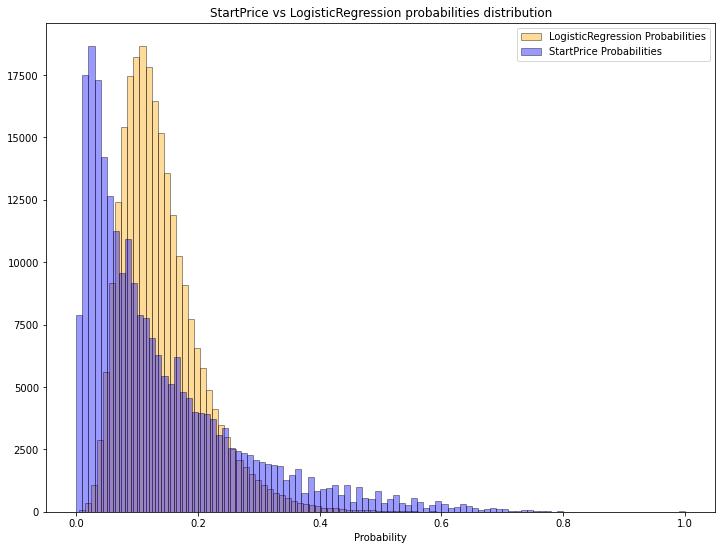

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

bins = 100
fig = plt.figure(figsize=(12, 9))

# Plot probabilities distribution
sns.distplot(test_data['prob_LogisticRegression'], hist=True, kde=False, 
             bins=bins, color = 'orange',
             hist_kws={'edgecolor':'black'})

# Plot Start Price probabilities
sns.distplot(test_data['StartPrice_probability'], hist=True, kde=False, 
             bins=bins, color = 'blue',
             hist_kws={'edgecolor':'black'})

plt.title('StartPrice vs LogisticRegression probabilities distribution')
plt.xlabel('Probability')
plt.legend(labels=['LogisticRegression Probabilities','StartPrice Probabilities'])
plt.show()

Probabilities generated by the Logistic Regression model follow a slightly different distribution. Scikit-learn framework offers various hyper parameters to fine tune a model and achieve better performances.

### Predictions calibration

We want to ensure that probabilities generated by our model match real world probabilities. Calibration curves help us understand if a model needs to be calibrated.

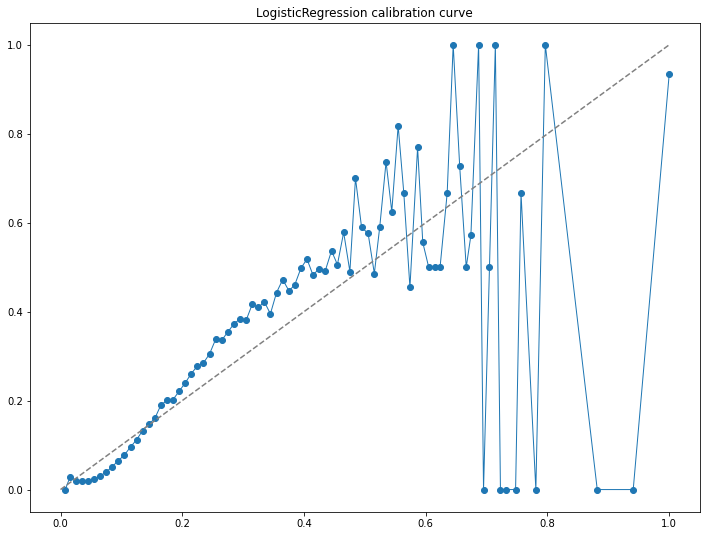

In [19]:
from sklearn.calibration import calibration_curve

bins = 100
fig = plt.figure(figsize=(12, 9))

# Generate calibration curves based on our probabilities
cal_y, cal_x = calibration_curve(test_data['win'], test_data['prob_LogisticRegression'], n_bins=bins)

# Plot against reference line
plt.plot(cal_x, cal_y, marker='o', linewidth=1)
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("LogisticRegression calibration curve");

A models is perfectly calibrated if the grouped values (bins) follow the dotted line. Our model generate probabilities that need to be calibrated.

To get our model to generate more accurate probabilities, we would need to generate better features, test various modelling approaches and calibrate generated probabilities.

### Compare other types of classification models

The next cell trains different Classification models using Scikit-learn unified API:
- [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
- [LGBMClassifier](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)
- [XGBClassifier](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier)
- [CatBoostClassifier](https://catboost.ai/docs/concepts/python-reference_catboostclassifier)

Depending on dataset size and compute capacity, this can take several minutes

In [20]:
from matplotlib import pyplot
from matplotlib.pyplot import figure

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import normalize

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Common models parameters
verbose       = 0
learning_rate = 0.1
n_estimators  = 100

# Train different types of models
models = {
    'LogisticRegression':         LogisticRegression(verbose=0, n_jobs=-1),
    'GradientBoostingClassifier': GradientBoostingClassifier(verbose=verbose, learning_rate=learning_rate, n_estimators=n_estimators, max_depth=3, max_features=0.25),
    'RandomForestClassifier':     RandomForestClassifier(verbose=verbose, n_estimators=n_estimators, max_depth=8, max_features=0.5, n_jobs=-1),
    'LGBMClassifier':             LGBMClassifier(verbose=verbose, learning_rate=learning_rate, n_estimators=n_estimators),
    'XGBClassifier':              XGBClassifier(verbosity=verbose, learning_rate=learning_rate, n_estimators=n_estimators, objective='binary:logistic'),
    'CatBoostClassifier':         CatBoostClassifier(verbose=verbose, learning_rate=learning_rate, n_estimators=n_estimators)
}

print(f'Training on {len(train_x):,} samples with {len(feature_cols)} features')
for key, model in models.items():
    print(f'Fitting model {key}')
    model.fit(train_x, train_y)

Training on 630,306 samples with 77 features
Fitting model LogisticRegression
Fitting model GradientBoostingClassifier
Fitting model RandomForestClassifier


/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Fitting model LGBMClassifier
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Fitting model XGBClassifier


/home/bruno/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fitting model CatBoostClassifier


### Visualise models predictions

Here we generate some probabilities using our trained models and compare them with the start price.

In <span style="color:blue">blue</span> the lowest prediction and in <span style="color:red">red</span> the highest prediction generated by the different models.

In [21]:
# Calculate probabilities for each model on the test dataset
probs_columns = ['StartPrice_probability']
for key, model in models.items():
    probs_column_key = f'prob_{key}'
    # Calculate runner win probability
    dog_win_probs = model.predict_proba(test_x)[:,1]
    test_data[probs_column_key] = dog_win_probs
    # Normalise probabilities
    test_data[probs_column_key] = test_data.groupby('FastTrack_RaceId')[f'prob_{key}'].apply(lambda x: x / sum(x))
    probs_columns.append(probs_column_key)

# Display and format sample results
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')
def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')

test_data[probs_columns].sample(20).style \
    .bar(color='#FFA07A', vmin=0.01, vmax=0.25, axis=1) \
    .apply(highlight_max, props='color:red;', axis=1) \
    .apply(highlight_min, props='color:blue;', axis=1)

,StartPrice_probability,prob_LogisticRegression,prob_GradientBoostingClassifier,prob_RandomForestClassifier,prob_LGBMClassifier,prob_XGBClassifier,prob_CatBoostClassifier
186002,0.132726,0.134295,0.163364,0.138908,0.174015,0.161347,0.149230
55682,0.008306,0.070567,0.075370,0.074783,0.074248,0.074771,0.075328
18818,0.053744,0.101223,0.124814,0.140164,0.095103,0.098227,0.124140
35614,0.022682,0.069434,0.084248,0.085627,0.084526,0.078451,0.075007
72240,0.020304,0.063400,0.059135,0.054700,0.037040,0.033417,0.056055
13190,0.010284,0.087410,0.055449,0.038972,0.052393,0.050946,0.048854
223157,0.681625,0.373802,0.348149,0.352170,0.373814,0.364001,0.381943
20332,0.053549,0.181665,0.179830,0.200601,0.187394,0.180735,0.206034
227238,0.566445,0.276535,0.260120,0.219649,0.259359,0.257498,0.267248
76045,0.026488,0.072916,0.086024,0.081953,0.076993,0.081527,0.080367


### Calculate models strike rate

Here we compare the strike rate of the different models with the start price strike rate.

In [22]:
# Create a boolean column for whether a dog has the higehst model prediction in a race.
# Do the same for the starting price as a comparison
test_dataset_size = test_data['FastTrack_RaceId'].nunique()
odds_win_prediction = test_data.groupby('FastTrack_RaceId')['StartPrice_probability'].apply(lambda x: x == max(x))
odds_win_prediction_percent = len(test_data[(odds_win_prediction == True) & (test_data['win'] == 1)]) / test_dataset_size
print(f"Starting Price Odds predicts the winner in {odds_win_prediction_percent:.2%} of races")

for key, model in models.items():
    predicted_winners = test_data.groupby('FastTrack_RaceId')[f'prob_{key}'].apply(lambda x: x == max(x))
    print('Model {} predicts the winner in {:.2%} of races'.format(key,
        len(test_data[(predicted_winners == True) & (test_data['win'] == 1)]) / test_data['FastTrack_RaceId'].nunique()
        ))

Starting Price Odds predicts the winner in 42.24% of races
Model LogisticRegression predicts the winner in 32.37% of races
Model GradientBoostingClassifier predicts the winner in 33.28% of races
Model RandomForestClassifier predicts the winner in 33.23% of races
Model LGBMClassifier predicts the winner in 33.21% of races
Model XGBClassifier predicts the winner in 33.45% of races
Model CatBoostClassifier predicts the winner in 33.33% of races


We now have built a simple feature set and trained models using various classification techniques. To improve our model performances, one should build a more advanced feature set and fine tune models hyper parameters.